In [2]:
import sys
sys.path.append('/Users/billystrickland/Documents/code/resonators')
import utils.resonator_functions as rf
import numpy as np
from shabanipy.jy_mpl_settings.settings import jy_mpl_rc
from shabanipy.jy_mpl_settings.colors import line_colors

from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.style.use(jy_mpl_rc)

root = '/Users/billystrickland/Documents/code/resonators/data/'

[Q0, Qtls, nc, beta] [1.96e+05 1.18e+03 3.46e+03 5.00e-01]
error [Q0, Qtls, nc, beta] [1.14e+04 3.79e+02 6.54e+03 4.15e-01]
[Q0, Qtls, nc, beta] [2.14e+05 1.33e+03 1.14e+04 4.90e-01]
error [Q0, Qtls, nc, beta] [1.43e+04 2.60e+02 1.10e+04 3.11e-01]
[Q0, Qtls, nc, beta] [6.31e+04 3.24e+02 1.43e-02 4.90e-01]
error [Q0, Qtls, nc, beta] [1.14e+03 1.44e+04 1.38e+00 4.92e-01]


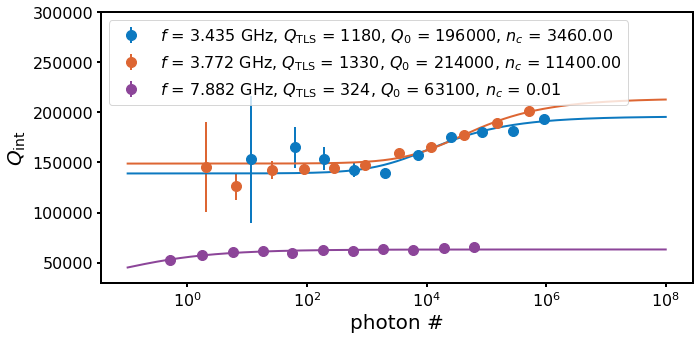

In [3]:
sample = '30SOF7_chipG_MBLJBWMS_CD01'
fig, ax = rf.make_plot_pre('photon #', '$Q_\mathrm{int}$', xscale = 'log', figsize = (10,5))
ax.set_yscale('linear')

markers = ['o', 's', '^', 'D', 'v', 'p', '*', 'H', '3', '2', '1']

def initialize(sample, ID, Q0 =31e3, c = 0, m = 0,Qtls = .85e3, nc = 9e4, label = 'label'):
    file = '/Users/billystrickland/Documents/code/resonators/data/'+sample+'/results/'
    FILES = []
    for i in range(len(ID)):
        FILES.append([file+ID[i]+'.csv'])
    photon_d = np.logspace(-1, 8, 10000)
    photon, qi_diacorr, qi_diacorr_err, freq, freq_err = [],[],[],[],[]
    for i in range(len(FILES)):
        results = rf.proc_csv(FILES[i])            
        photon1, power1, qi_diacorr1, qi_diacorr_err1, qc1, qc_err1, ql1, ql_err1, freq1, freq_err1 = rf.get_results(results, 100000) 
        photon.append(photon1)
        qi_diacorr.append(qi_diacorr1)
        qi_diacorr_err.append(qi_diacorr_err1)

    photon = np.concatenate(photon)
    qi_diacorr = np.concatenate(qi_diacorr)
    qi_diacorr_err = np.concatenate(qi_diacorr_err)
    def func_tls(n, Q0, Qtls, nc, beta):
        kb = 8.617e-5
        h = 4.136e-15
        return 1/((1/Q0)+(1/(Qtls*(1+(n/nc))**beta/np.tanh(h*freq1[0]/kb*(15e-3)))))

    popt, pcov = curve_fit(func_tls, photon, qi_diacorr,sigma = qi_diacorr_err,
                        p0 = [Q0, Qtls, nc, 0.5],
                        bounds=([0, 0,  0, 0.49], [np.inf, np.inf, np.inf, .50001]),
                        maxfev = 1000000000
                       )
    perr = np.sqrt(np.diag(pcov))
    def round_to_n(x, n):
        if x == 0:
            return 0
        else:
            return round(x, -int(np.floor(np.log10(abs(x)))) + (n - 1))

    popt = np.vectorize(lambda x: round_to_n(x, 3))(popt)
    perr = np.vectorize(lambda x: round_to_n(x, 3))(perr)
    print('[Q0, Qtls, nc, beta]', popt)
    print('error [Q0, Qtls, nc, beta]', perr)

    ax.errorbar(np.array(photon),qi_diacorr,yerr=qi_diacorr_err,
                linestyle = 'None',color=line_colors[c], marker = markers[m], 
                label = label+', $Q_\mathrm{TLS}$ = '+str(int(popt[1]))+', $Q_0$ = '+str(int(popt[0]))+f', $n_c$ = {popt[2]:.2f}')
    plt.plot(photon_d, func_tls(photon_d, *popt), 
             color = line_colors[c],)
    plt.ylim(30000, 300000)
#     plt.yscale('log')
    plt.legend()
        
data = [
    {'ID': ['033_0'], 'Q0': 26e3, 'Qtls': 0.6e3, 'c': 0, 'm':0, 'nc': 9e4, 
     'label': '$f$ = 3.435 GHz'},
    {'ID': ['033_1'], 'Q0': 26e3, 'Qtls': 0.6e3, 'c': 1, 'm':0, 'nc': 9e4, 
     'label': '$f$ = 3.772 GHz'},
    {'ID': ['034_0'], 'Q0': 26e3, 'Qtls': 0.6e3, 'c': 2, 'm':0, 'nc': 9e4, 
     'label': '$f$ = 7.882 GHz'},
]

for entry in data:
    initialize(sample, entry['ID'], Q0=entry['Q0'], Qtls=entry['Qtls'], c=entry['c'], m = entry['m'], nc=entry['nc'], label=entry['label'])

fig.tight_layout()
plt.savefig(root+'/'+sample+'/'+'results/power-tls.pdf', format = 'pdf')

[269029.7394526  253541.58748709 243602.1093177  236449.37033429
 228164.28487508 221732.70294208 218962.92067652 212383.3336194
 208240.07413236 205735.20048332 203693.66262334 201695.4513477
 196142.48989286 193904.98587263 192600.98664162 187764.63331514
 187884.48646231 183919.03246133 180982.06663286 180337.72236874
 176955.99029732 175321.32731322 171771.48919251 170207.57693838
 167662.07825476 162424.22508815 162034.084153   157114.35523748
 156158.98239964 151684.9332966  150199.80846416 146067.30020367
 144049.60537799 140488.90344207 138189.88509201 135465.57092573
 129452.447962   128275.77832591 122516.03143366 121072.08045946
 118652.16402176 115517.84771967 107797.65780853 109616.32972342
 104461.84192566 100785.28344835 101109.58737163  95213.50648152
  94651.89086467  86904.21881613  86032.94146027  84392.80801121
  84844.2037151   82275.91387888  80451.05378514  78560.67112913
  75863.93838158  74307.26415439  72824.46276994  70577.26875703
  62126.00072535] [33794.60

<ipython-input-42-b2406f591be9>:32: RuntimeWarning: invalid value encountered in power
  return 1/((1/Q0)+(1/(Qtls*(1+(n/nc))**beta/np.tanh(h*freq1[0]/kb*(15e-3)))))
<ipython-input-42-b2406f591be9>:32: RuntimeWarning: invalid value encountered in power
  return 1/((1/Q0)+(1/(Qtls*(1+(n/nc))**beta/np.tanh(h*freq1[0]/kb*(15e-3)))))


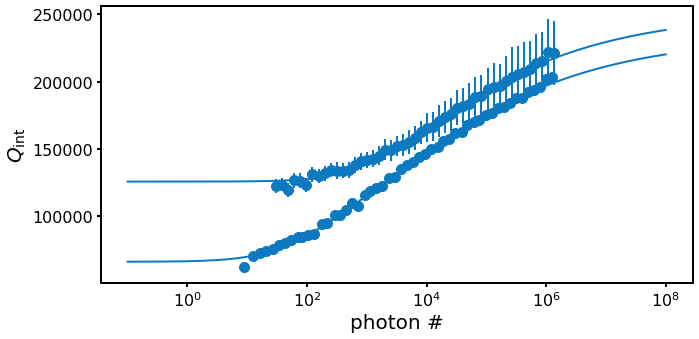

In [42]:
sample = 'Al-Ge_7bareresonators-v1.2-01_BHEPJS01'
fig, ax = rf.make_plot_pre('photon #', '$Q_\mathrm{int}$', xscale = 'log', figsize = (10,5))
ax.set_yscale('linear')
# plt.ylim(0, 70000)
# plt.xlim(0, 1e3)
markers = ['o', 's', '^', 'D', 'v', 'p', '*', 'H', '3', '2', '1']

def initialize(sample, ID, Q0 =31e3, c = 0, m = 0,Qtls = .85e3, nc = 9e4, label = 'label'):
#     file = '/Users/billystrickland/Documents/code/resonators/data/'+sample+'/results/'
    file = '/Users/billystrickland/Downloads/InP-Nb_LO-7barresonators-v1_power_'
    FILES = []
    for i in range(len(ID)):
        FILES.append([file+ID[i]+'.csv'])
    photon_d = np.logspace(-1, 8, 10000)
    photon, qi_diacorr, qi_diacorr_err, freq, freq_err = [],[],[],[],[]
    for i in range(len(FILES)):
        results = rf.proc_csv(FILES[i])            
        photon1, power1, qi_diacorr1, qi_diacorr_err1, qc1, qc_err1, ql1, ql_err1, freq1, freq_err1 = rf.get_results(results, 1e5) 
        photon.append(photon1)
        qi_diacorr.append(qi_diacorr1)
        qi_diacorr_err.append(qi_diacorr_err1)

    photon = np.concatenate(photon)
    qi_diacorr = np.concatenate(qi_diacorr)
    qi_diacorr_err = np.concatenate(qi_diacorr_err)
    print(qi_diacorr, qi_diacorr_err)
    lims = [0, 100]
    photon, qi_diacorr, qi_diacorr_err = photon[10::], qi_diacorr[10::], qi_diacorr_err[10::]
    def func_tls(n, Q0, Qtls, nc, beta):
        kb = 8.617e-5
        h = 4.136e-15
        return 1/((1/Q0)+(1/(Qtls*(1+(n/nc))**beta/np.tanh(h*freq1[0]/kb*(15e-3)))))

    popt, pcov = curve_fit(func_tls, photon, qi_diacorr,
                        p0 = [Q0, Qtls, nc, 0.5],
                        bounds=([0, 0,  -np.inf, 0.25], [np.inf, np.inf, np.inf, .75]),
                        maxfev = 1000000000
                       )
    perr = np.sqrt(np.diag(pcov))
    def round_to_n(x, n):
        if x == 0:
            return 0
        else:
            return round(x, -int(np.floor(np.log10(abs(x)))) + (n - 1))

    popt = np.vectorize(lambda x: round_to_n(x, 3))(popt)
    perr = np.vectorize(lambda x: round_to_n(x, 3))(perr)
    print('[Q0, Qtls, nc, beta]', popt)
    print('error [Q0, Qtls, nc, beta]', perr)

    ax.errorbar(np.array(photon),qi_diacorr,yerr=qi_diacorr_err,
                linestyle = 'None',color=line_colors[c], marker = markers[m], 
                label = label+', $Q_\mathrm{TLS}$ = '+str(int(popt[1]))+', $Q_0$ = '+str(int(popt[0])))
    plt.plot(photon_d, func_tls(photon_d, *popt), 
             color = line_colors[c],)

        
data = [
    {'ID': ['8.5GHz'], 'Q0': 500e3, 'Qtls': 0.6e3, 'c': 0, 'm':0, 'nc': 9e4, 
     'label': 'R1, 30um center'},
    {'ID': ['5.14GHz'], 'Q0': 26e3, 'Qtls': 0.6e3, 'c': 0, 'm':0, 'nc': 9e4, 
     'label': 'R1, 30um center'},
#     {'ID': ['6.52GHz'], 'Q0': 26e3, 'Qtls': 0.6e3, 'c': 0, 'm':0, 'nc': 9e4, 
#      'label': 'R1, 30um center'},
#     {'ID': ['0080'], 'Q0': 26e3, 'Qtls': 0.6e3, 'c': 0, 'm':0, 'nc': 9e4, 
#      'label': 'R1, 30um center'},
#         {'ID': ['0081'], 'Q0': 26e3, 'Qtls': 0.6e3, 'c': 1, 'm':0, 'nc': 9e4, 
#      'label': 'R2, 10um center'},
#         {'ID': ['0082'], 'Q0': 26e3, 'Qtls': 0.6e3, 'c': 2, 'm':0, 'nc': 9e4, 
#      'label': 'R3, 35um center'},
#             {'ID': ['0083'], 'Q0': 26e3, 'Qtls': 0.6e3, 'c': 3, 'm':0, 'nc': 9e4, 
#      'label': 'R4, 25um center'},
#             {'ID': ['0084'], 'Q0': 26e3, 'Qtls': 0.6e3, 'c': 4, 'm':0, 'nc': 9e4, 
#      'label': 'R6, 15um center'},
#             {'ID': ['0085'], 'Q0': 26e3, 'Qtls': 0.6e3, 'c': 5, 'm':0, 'nc': 9e4, 
#      'label': 'R7, 12um center'},
# #             {'ID': ['0086'], 'Q0': 26e3, 'Qtls': 0.6e3, 'c': 6, 'm':0, 'nc': 9e4, 
# #      'label': 'R1, 10um center'},
    
]

for entry in data:
    initialize(sample, entry['ID'], Q0=entry['Q0'], Qtls=entry['Qtls'], c=entry['c'], m = entry['m'], nc=entry['nc'], label=entry['label'])

fig.tight_layout()
plt.savefig(root+'/'+sample+'/'+'results/power-tls.eps', format = 'eps')

Text(0, 0.5, 'Qtls')

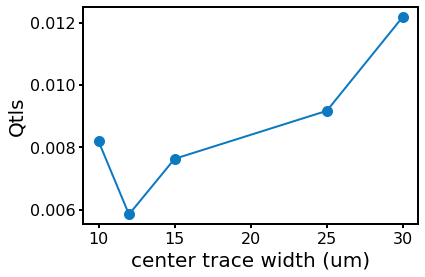

In [7]:
Qtls = [82, 122, 
#         11, 
        109, 131, 171]
center = [30, 10, 
#           35,
          25, 15, 12]

center, Qtls = zip(*sorted(zip(center, Qtls)))
plt.plot(center, 1/np.array(Qtls), marker = 'o')
plt.xlabel('center trace width (um)')
plt.ylabel('Qtls')

[Q0, Qtls, nc, beta] [2.71e+04 4.04e+02 1.47e+05 5.00e-01]
error [Q0, Qtls, nc, beta] [2.08e+03 9.27e+01 1.27e+05 3.85e-01]
[Q0, Qtls, nc, beta] [4.36e+04 2.43e+03 1.30e+04 5.00e-01]
error [Q0, Qtls, nc, beta] [6.52e+02 4.75e+02 1.60e+04 3.98e-01]
[Q0, Qtls, nc, beta] [8.39e+03 3.39e+07 3.89e+07 5.00e-01]
error [Q0, Qtls, nc, beta] [2.90e+03 9.33e+12 1.82e+13 2.70e+05]
[Q0, Qtls, nc, beta] [1.77e+03 6.11e+00 1.05e-01 5.00e-01]
error [Q0, Qtls, nc, beta] [148.      9.29    0.665   0.602]


<ipython-input-14-ebde2d7e52fd>:28: RuntimeWarning: invalid value encountered in power
  return 1/((1/Q0)+(1/(Qtls*(1+(n/nc))**beta/np.tanh(h*freq1[0]/kb*(15e-3)))))
<ipython-input-14-ebde2d7e52fd>:28: RuntimeWarning: invalid value encountered in power
  return 1/((1/Q0)+(1/(Qtls*(1+(n/nc))**beta/np.tanh(h*freq1[0]/kb*(15e-3)))))


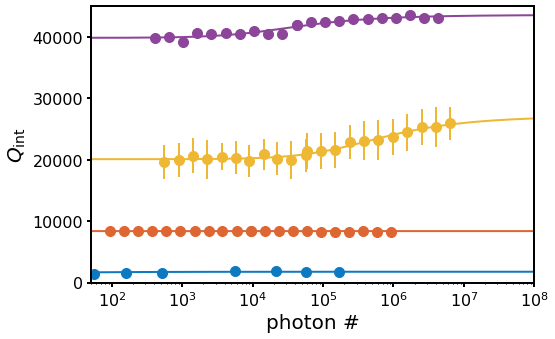

In [30]:
sample = 'JS681-6CLQ-005-BSLB-001'
fig, ax = rf.make_plot_pre('photon #', '$Q_\mathrm{int}$', xscale = 'log', figsize = (8,5))
ax.set_yscale('linear')
plt.ylim(0, 45000)
plt.xlim(5e1, 1e8)

markers = ['o', 's', '^', 'D', 'v', 'p', '*', 'H', '3', '2', '1']

data = [
#     {'ID': ['0030', '0040'], 'Q0': 26e3, 'Qtls': 0.6e3, 'c': 2, 'nc': 9e4, 'label': 'R1'},
#     {'ID': ['0031', '0041'], 'Q0': 26e3, 'Qtls': 0.6e3, 'c': 2, 'nc': 9e4, 'label': 'R2'},
    {'ID': ['0032', '0042'], 'Q0': 26e3, 'Qtls': 0.6e3, 'c': 3, 'nc': 9e4, 'label': '30+200 nm, R4'},
#     {'ID': ['0033', '0043'], 'Q0': 40e3, 'Qtls': 0.55e3, 'c': 3, 'nc': 2e5, 'label': '30+200 nm, R5'},
#     {'ID': ['0034', '0044'], 'Q0': 36e3, 'Qtls': 0.6e3, 'c': 4, 'nc': 1e5, 'label': '30+200 nm, R6'},
]

for entry in data:
    initialize(sample, entry['ID'], Q0=entry['Q0'], Qtls=entry['Qtls'], c=entry['c'], nc=entry['nc'], label=entry['label'])

sample = 'JS681-6CLQ-003-BS-001'

data = [
    {'ID': ['0062', '0072'], 'Q0': 40e3, 'Qtls': 0.85e3, 'c': 2, 'nc': 4e5, 'label': '30+100 nm, R4'},
#     {'ID': ['0063', '0073'], 'Q0': 34e3, 'Qtls': 0.85e3, 'c': 6, 'nc': 9e4, 'label': '30+100 nm, R5'},
#     {'ID': ['0064', '0074'], 'Q0': 30e3, 'Qtls': 0.6e3, 'c': 7, 'nc': 9e4, 'label': '30+100 nm, R6'},
]

for entry in data:
    initialize(sample, entry['ID'], Q0=entry['Q0'], Qtls=entry['Qtls'], c=entry['c'], nc=entry['nc'], label=entry['label'])


sample = 'JS681-6CLQ-004-BSLB-001'

data = [
#     {'ID': ['0100', '0120'], 'Q0': 7e3, 'Qtls': 50e3, 'c': 8, 'nc': 9e4, 'label': 'R3'},
#     {'ID': ['0101', '0121'], 'Q0': 7e3, 'Qtls': 50e3, 'c': 9, 'nc': 9e4, 'label': 'R3'},
    {'ID': ['0102', '0122'], 'Q0': 7e3, 'Qtls': 50e3, 'c': 1, 'nc': 9e4, 'label': '30+30 nm, R4'},
#     {'ID': ['0103', '0123'], 'Q0': 7e3, 'Qtls': 50e3, 'c': 1, 'nc': 9e4, 'label': '30+30 nm, R5'},
#     {'ID': ['0104', '0124'], 'Q0': 7e3, 'Qtls': 50e3, 'c': 2, 'nc': 9e4, 'label': '30+30 nm, R6'},
]

for entry in data:
    initialize(sample, entry['ID'], Q0=entry['Q0'], Qtls=entry['Qtls'], c=entry['c'], nc=entry['nc'], label=entry['label'])

sample = 'JS631-6cavlowq-1-BS-001'

data = [
#     {'ID': ['res0'], 'Q0': 7e3, 'Qtls': 50e3, 'c': 3, 'nc': 9e4, 'label': 'R3'},
#     {'ID': ['res1'], 'Q0': 7e3, 'Qtls': 50e3, 'c': 4, 'nc': 9e4, 'label': 'R3'},
    {'ID': ['res2'], 'Q0': 7e3, 'Qtls': 50e3, 'c': 0, 'nc': 9e4, 'label': '30 nm, R4'},
#     {'ID': ['res3'], 'Q0': 7e3, 'Qtls': 50e3, 'c': 6, 'nc': 9e4, 'label': '30 nm, R5'},
#     {'ID': ['res4'], 'Q0': 7e3, 'Qtls': 50e3, 'c': 7, 'nc': 9e4, 'label': '30 nm, R6'},
]

for entry in data:
    initialize(sample, entry['ID'], Q0=entry['Q0'], Qtls=entry['Qtls'], c=entry['c'], nc=entry['nc'], label=entry['label'])

    
fig.tight_layout()
plt.savefig('power-tls.png')